In [1]:
import numpy as np
import cv2
import time
import random
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def read_img(file):
    img_feat_list,label_list = [],[]
    with open(file) as f:
        for i in f:
            img_info = i.split(" ")
            img_name = img_info[0]
            img = cv2.imread(img_name,cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img,(128,128))
            img_feat = img/255.0
            img_feat_list.append(img_feat)
            
            label = int(img_info[-1])
            label_onehot = np.zeros(50)
            label_onehot[label] = 1
            label_list.append(label_onehot)
    return np.array(img_feat_list),np.array(label_list)

In [3]:
%%time
train_feat,train_label = read_img("train.txt")
val_feat,val_label = read_img("val.txt")
test_feat,test_label = read_img("test.txt")

CPU times: user 50.6 s, sys: 10.4 s, total: 1min 1s
Wall time: 1min 11s


# Reference：https://github.com/chuanqi305/LeNet5

In [4]:
class Trainable(object):
    learning_rate = 0.0003
    learning_rate_decay = 0.001
    momentum = 0.95
    epoch = 10
    batch_size = 32
    weight_decay = 0.001

    def __init__(self):
        self.weight_diff = 0
        self.bias_diff = 0

    def sgd_momentum(self, weight_diff, bias_diff):
        self.weight_diff = self.momentum * self.weight_diff + (1 - self.momentum) * weight_diff
        self.bias_diff = self.momentum * self.bias_diff + (1 - self.momentum) * bias_diff
        return self.weight_diff, self.bias_diff

In [5]:
class Conv(Trainable):
    def __init__(self, name, kernel, inc, outc):
        super(Conv, self).__init__()
        self.name = name
        self.kernel = kernel
        self.inc = inc
        self.outc = outc
        self.weight = np.random.randn(kernel, kernel, inc, outc) * np.sqrt(2.0 / (kernel * kernel * inc)) #msra
        self.bias = np.zeros(outc)

    def forward(self, x):
        self.x = x
        k = self.kernel
        n, h, w, c = x.shape
        h_out = h - (k - 1)
        w_out = w - (k - 1)
        weight = self.weight.reshape(-1, self.outc)
        output = np.zeros((n, h_out, w_out, self.outc))
        for i in range(h_out):
            for j in range(w_out):
                inp = x[:, i:i+k, j:j+k, :].reshape(n, -1)
                out = inp.dot(weight) + self.bias
                output[:, i, j, :] = out.reshape(n, -1)
        return output

    def backward(self, diff):
        n, h, w, c = diff.shape
        k = self.kernel
        h_in = h + (k - 1)
        w_in = w + (k - 1)

        weight_diff = np.zeros((k, k, self.inc, self.outc))
        for i in range(k):
            for j in range(k):
                #inp = (n, 28, 28, c) => (n*28*28, c) => (c, n*28*28)
                inp = self.x[:, i:i+h, j:j+w, :].reshape(-1, self.inc).T
                #diff = n, 28, 28, 6 => (n*28*28, 6)
                diff_out = diff.reshape(-1, self.outc)
                weight_diff[i, j, :, :] = inp.dot(diff_out)
        bias_diff = np.sum(diff, axis=(0, 1, 2))

        pad = k - 1
        diff_pad = np.pad(diff, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant')
        rotated_weight = self.weight[::-1, ::-1, :, :].transpose(0, 1, 3, 2).reshape(-1, self.inc)
        back_diff = np.zeros((n, h_in, w_in, self.inc))
        for i in range(h_in):
            for j in range(w_in):
                diff_out = diff_pad[:, i:i+k, j:j+k, :].reshape(n, -1)
                out = diff_out.dot(rotated_weight)
                back_diff[:, i, j, :] = out.reshape(n, -1)

        weight_diff, bias_diff = self.sgd_momentum(weight_diff, bias_diff)
        self.weight -= Trainable.learning_rate * weight_diff + Trainable.weight_decay * self.weight
        self.bias -= Trainable.learning_rate * bias_diff + Trainable.weight_decay * self.bias

        return back_diff

In [6]:
class Pooling():
    def forward(self, x):
        n, h, w, c = x.shape
        x_grid = x.reshape(n, h // 2, 2, w // 2, 2, c)
        out = np.max(x_grid, axis=(2, 4))
        self.mask = (out.reshape(n, h // 2, 1, w // 2, 1, c) == x_grid)
        return out

    def backward(self, diff):
        n, h, w, c = diff.shape
        diff_grid = diff.reshape(n, h, 1, w, 1, c)
        return (diff_grid * self.mask).reshape(n, h * 2, w * 2, c)

In [7]:
# class ReLU():
#     def forward(self, x):
#         self.x = x
#         return (x > 0) * x

#     def backward(self, diff):
#         return (self.x > 0) * diff
class sigmoid():
    def __init__(self):
        pass
    def forward(self,x):
        self.x = x
        self.x1 = -self.x
        self.x2 = np.exp(self.x1)
        self.x3 = 1 + self.x2
        output = 1 / self.x3
        return output
    def backward(self,upg): # upg:upstream gradient
        gd3 = upg * (-1 / (self.x3)**2)
        gd2 = gd3 * 1
        gd1 = gd2 * np.exp(self.x1)
        gd0 = gd1 * -1
        return gd0

In [8]:
class FC(Trainable):
    def __init__(self, name, inc, outc):
        super(FC, self).__init__()
        self.name = name
        self.weight = np.random.randn(inc, outc) * np.sqrt(2.0 / inc) #msra
        self.bias = np.zeros(outc)

    def forward(self, x):
        self.origin_shape = x.shape
        if x.ndim == 4:
            x = x.reshape(x.shape[0], -1)
        self.x = x
        return x.dot(self.weight) + self.bias
   
    def backward(self, diff):
        #diff = (n, 10)
        #self.x = (n, 1024) => (1024, n)
        weight_diff = self.x.T.dot(diff)
        bias_diff = np.sum(diff, axis=0)
        #weight = (1024, 10) => (10, 1024), back_diff = (n, 1024)
        back_diff = diff.dot(self.weight.T).reshape(self.origin_shape)

        weight_diff, bias_diff = self.sgd_momentum(weight_diff, bias_diff)
        self.weight -= Trainable.learning_rate * weight_diff + Trainable.weight_decay * self.weight
        self.bias -= Trainable.learning_rate * bias_diff + Trainable.weight_decay * self.bias
        return back_diff

In [9]:
class SoftmaxLoss():
    def forward(self, x):
        softmax = np.exp(x) / np.sum(np.exp(x), axis=1).reshape(-1, 1)
        self.softmax = softmax
        # output = np.argmax(softmax, axis=1)
        if not hasattr(self, 'y'):
            return softmax
        y = self.y
        label = np.argmax(y, axis=1)
        loss = -np.sum(y * np.log(softmax) + (1 - y) * np.log(1 - softmax))
        # accuracy = np.sum(output==label) / float(len(label))
        accuracy = (softmax.argmax(1) == label).sum()
        accuracy_top5 = len([i for i in range(len(label)) if label[i] in np.argsort(-softmax,axis=1)[i,:5]])
        return loss, accuracy, accuracy_top5

    def backward(self, diff):
        return self.softmax - self.y

    def set_label(self, label):
        self.y = label

In [29]:
class LeNet:
    def __init__(self):
        conv1 = Conv("conv1", 5, 1, 6)
        pool1 = Pooling()
        sigmoid1 = sigmoid()
        conv2 = Conv("conv2", 5, 6, 16)
        pool2 = Pooling()
        sigmoid2 = sigmoid()
        fc3 = FC("fc3", 29*29*16, 120)
        sigmoid3 = sigmoid()
        fc4 = FC("fc4", 120, 84)
        sigmoid4 = sigmoid()
        fc5 = FC("fc5", 84, 50)
        loss = SoftmaxLoss()
        self.layers = [conv1, pool1, sigmoid1, conv2, pool2, sigmoid2, fc3, sigmoid3, fc4, sigmoid4, fc5, loss]

    def train(self, train_images, train_labels, val_images, val_labels):
        
        batch_size = Trainable.batch_size
        train_index = np.arange(train_images.shape[0])
        val_index = np.arange(val_images.shape[0])
        train_num_batch = len(train_index)//batch_size
        val_num_batch = len(val_index)//batch_size
        train_acc, train_acc_top5, train_loss = [],[],[]
        val_acc, val_acc_top5, val_loss = [],[],[]
        for i in tqdm(range(Trainable.epoch)):
            random.shuffle(train_index)
            train_images = train_images[train_index]
            train_labels = train_labels[train_index]
            total_train_acc, total_train_acc_top5, total_train_loss = 0,0,0
            for j in range(train_num_batch):
                x = train_images[j*batch_size : (j+1)*batch_size]
                y = train_labels[j*batch_size : (j+1)*batch_size]
            # x = images[index:index + batch_size] #mini batch sgd
            # y = labels[index:index + batch_size]
            # index += batch_size
            # index = index % len(images)

                loss = self.layers[-1]
                loss.set_label(y)

                for layer in self.layers:
                    # print(x.shape)
                    x = layer.forward(x)
                # collect loss,accuracy from each mini batch
                total_train_loss += x[0]
                total_train_acc += x[1]
                total_train_acc_top5 += x[2]
                
                if (j+1)%200 == 0:
                    print("step %d: loss=%.6f, accuracy=%.4f, lr=%g" % (j+1, x[0]/batch_size, x[1]/batch_size, Trainable.learning_rate))
                
                diff = 1.0
                for layer in reversed(self.layers):
                    diff = layer.backward(diff)
                Trainable.learning_rate *= (1 - Trainable.learning_rate_decay)
                
            train_loss.append(total_train_loss/len(train_labels))
            train_acc.append(total_train_acc/len(train_labels))
            train_acc_top5.append(total_train_acc_top5/len(train_labels))
            
            
            
            del loss.y
            
            total_val_acc, total_val_acc_top5, total_val_loss = 0,0,0
            for j in range(val_num_batch):
                x = val_images[j*batch_size : (j+1)*batch_size]
                y = val_labels[j*batch_size : (j+1)*batch_size]
                for layer in self.layers:
                    x = layer.forward(x)
                loss_value = -np.sum(y * np.log(x) + (1 - y) * np.log(1 - x))
                total_val_loss += loss_value
                label = np.argmax(y, axis=1)
                acc = (x.argmax(1) == label).sum()
                total_val_acc += acc
                acc_top5 = len([k for k in range(len(label)) if label[k] in np.argsort(-x,axis=1)[k,:5]])
                total_val_acc_top5 += acc_top5
            val_loss.append(total_val_loss/len(val_labels))
            val_acc.append(total_val_acc/len(val_labels))
            val_acc_top5.append(total_val_acc_top5/len(val_labels))
                
                
        return train_loss, train_acc, train_acc_top5, val_loss, val_acc, val_acc_top5
    def predict(self, images):
        x = images
        for layer in self.layers:
            x = layer.forward(x)
        return x

In [11]:
%%time
lenet = LeNet()
train_result = lenet.train(np.expand_dims(train_feat,axis=3), train_label, np.expand_dims(val_feat,axis=3), val_label)

  0%|          | 0/10 [00:00<?, ?it/s]

step 200: loss=4.936338, accuracy=0.0625, lr=0.00024584
step 400: loss=4.924501, accuracy=0.0625, lr=0.000201257
step 600: loss=4.920129, accuracy=0.0312, lr=0.000164759
step 800: loss=4.902146, accuracy=0.0000, lr=0.00013488
step 1000: loss=4.897440, accuracy=0.0312, lr=0.000110419
step 1200: loss=4.906838, accuracy=0.0000, lr=9.03944e-05
step 1400: loss=4.891395, accuracy=0.0625, lr=7.40013e-05
step 1600: loss=4.899447, accuracy=0.0625, lr=6.05811e-05
step 1800: loss=4.904765, accuracy=0.0000, lr=4.95946e-05


 10%|█         | 1/10 [30:39<4:35:51, 1839.07s/it]

step 200: loss=4.898522, accuracy=0.0000, lr=3.39773e-05
step 400: loss=4.900861, accuracy=0.0000, lr=2.78155e-05
step 600: loss=4.896107, accuracy=0.0000, lr=2.27711e-05
step 800: loss=4.897364, accuracy=0.0312, lr=1.86416e-05
step 1000: loss=4.908390, accuracy=0.0000, lr=1.52609e-05
step 1200: loss=4.901638, accuracy=0.0625, lr=1.24933e-05
step 1400: loss=4.898800, accuracy=0.0000, lr=1.02276e-05
step 1600: loss=4.899853, accuracy=0.0625, lr=8.37284e-06
step 1800: loss=4.899347, accuracy=0.0312, lr=6.85441e-06


 20%|██        | 2/10 [1:01:35<4:06:34, 1849.27s/it]

step 200: loss=4.900780, accuracy=0.0312, lr=4.69596e-06
step 400: loss=4.903853, accuracy=0.0625, lr=3.84435e-06
step 600: loss=4.903208, accuracy=0.0312, lr=3.14717e-06
step 800: loss=4.900870, accuracy=0.0312, lr=2.57643e-06
step 1000: loss=4.900625, accuracy=0.0000, lr=2.10919e-06
step 1200: loss=4.900995, accuracy=0.0312, lr=1.72668e-06
step 1400: loss=4.901505, accuracy=0.0000, lr=1.41355e-06
step 1600: loss=4.902485, accuracy=0.0000, lr=1.1572e-06
step 1800: loss=4.902042, accuracy=0.0312, lr=9.4734e-07


 30%|███       | 3/10 [1:31:23<3:32:27, 1821.13s/it]

step 200: loss=4.901737, accuracy=0.0000, lr=6.49024e-07
step 400: loss=4.901941, accuracy=0.0000, lr=5.31322e-07
step 600: loss=4.902357, accuracy=0.0938, lr=4.34967e-07
step 800: loss=4.902002, accuracy=0.0000, lr=3.56085e-07
step 1000: loss=4.901711, accuracy=0.0000, lr=2.91508e-07
step 1200: loss=4.902420, accuracy=0.0000, lr=2.38643e-07
step 1400: loss=4.901874, accuracy=0.0000, lr=1.95365e-07
step 1600: loss=4.901794, accuracy=0.0000, lr=1.59935e-07
step 1800: loss=4.901824, accuracy=0.0312, lr=1.30931e-07


 40%|████      | 4/10 [2:00:16<2:58:38, 1786.46s/it]

step 200: loss=4.901900, accuracy=0.0000, lr=8.97008e-08
step 400: loss=4.902004, accuracy=0.0000, lr=7.34334e-08
step 600: loss=4.901950, accuracy=0.0312, lr=6.01162e-08
step 800: loss=4.901986, accuracy=0.0312, lr=4.92141e-08
step 1000: loss=4.902054, accuracy=0.0312, lr=4.0289e-08
step 1200: loss=4.901965, accuracy=0.0000, lr=3.29826e-08
step 1400: loss=4.901958, accuracy=0.0625, lr=2.70011e-08
step 1600: loss=4.901926, accuracy=0.0000, lr=2.21045e-08
step 1800: loss=4.901955, accuracy=0.0625, lr=1.80958e-08


 50%|█████     | 5/10 [2:29:03<2:27:05, 1765.05s/it]

step 200: loss=4.901966, accuracy=0.0312, lr=1.23974e-08
step 400: loss=4.901940, accuracy=0.0000, lr=1.01491e-08
step 600: loss=4.901957, accuracy=0.0000, lr=8.30859e-09
step 800: loss=4.901950, accuracy=0.0938, lr=6.80182e-09
step 1000: loss=4.901951, accuracy=0.0625, lr=5.5683e-09
step 1200: loss=4.901948, accuracy=0.0938, lr=4.55848e-09
step 1400: loss=4.901960, accuracy=0.0000, lr=3.7318e-09
step 1600: loss=4.901953, accuracy=0.0000, lr=3.05503e-09
step 1800: loss=4.901951, accuracy=0.0625, lr=2.501e-09


 60%|██████    | 6/10 [2:57:25<1:56:14, 1743.74s/it]

step 200: loss=4.901954, accuracy=0.0312, lr=1.71344e-09
step 400: loss=4.901956, accuracy=0.0625, lr=1.4027e-09
step 600: loss=4.901957, accuracy=0.0000, lr=1.14832e-09
step 800: loss=4.901954, accuracy=0.0625, lr=9.40071e-10
step 1000: loss=4.901954, accuracy=0.0312, lr=7.69588e-10
step 1200: loss=4.901954, accuracy=0.0312, lr=6.30022e-10
step 1400: loss=4.901955, accuracy=0.0312, lr=5.15767e-10
step 1600: loss=4.901955, accuracy=0.0312, lr=4.22232e-10
step 1800: loss=4.901955, accuracy=0.0000, lr=3.4566e-10


 70%|███████   | 7/10 [3:25:31<1:26:14, 1724.79s/it]

step 200: loss=4.901955, accuracy=0.0000, lr=2.36812e-10
step 400: loss=4.901955, accuracy=0.0625, lr=1.93866e-10
step 600: loss=4.901956, accuracy=0.0000, lr=1.58708e-10
step 800: loss=4.901955, accuracy=0.0000, lr=1.29926e-10
step 1000: loss=4.901956, accuracy=0.0000, lr=1.06364e-10
step 1200: loss=4.901956, accuracy=0.0000, lr=8.70746e-11
step 1400: loss=4.901956, accuracy=0.0312, lr=7.12835e-11
step 1600: loss=4.901956, accuracy=0.0625, lr=5.83562e-11
step 1800: loss=4.901956, accuracy=0.0312, lr=4.77732e-11


 80%|████████  | 8/10 [3:53:38<57:05, 1712.72s/it]  

step 200: loss=4.901956, accuracy=0.0625, lr=3.27295e-11
step 400: loss=4.901956, accuracy=0.0000, lr=2.6794e-11
step 600: loss=4.901956, accuracy=0.0000, lr=2.19348e-11
step 800: loss=4.901956, accuracy=0.0000, lr=1.79569e-11
step 1000: loss=4.901956, accuracy=0.0625, lr=1.47004e-11
step 1200: loss=4.901956, accuracy=0.0000, lr=1.20345e-11
step 1400: loss=4.901956, accuracy=0.0000, lr=9.85201e-12
step 1600: loss=4.901956, accuracy=0.0000, lr=8.06534e-12
step 1800: loss=4.901956, accuracy=0.0625, lr=6.60268e-12


 90%|█████████ | 9/10 [4:21:40<28:23, 1703.02s/it]

step 200: loss=4.901956, accuracy=0.0312, lr=4.5235e-12
step 400: loss=4.901956, accuracy=0.0000, lr=3.70316e-12
step 600: loss=4.901956, accuracy=0.0312, lr=3.03159e-12
step 800: loss=4.901956, accuracy=0.0625, lr=2.48181e-12
step 1000: loss=4.901956, accuracy=0.0312, lr=2.03173e-12
step 1200: loss=4.901956, accuracy=0.0000, lr=1.66327e-12
step 1400: loss=4.901956, accuracy=0.0000, lr=1.36163e-12
step 1600: loss=4.901956, accuracy=0.0000, lr=1.1147e-12
step 1800: loss=4.901956, accuracy=0.0312, lr=9.12549e-13


100%|██████████| 10/10 [4:49:55<00:00, 1739.56s/it]

CPU times: user 1d 7h 15min 10s, sys: 3d 6h 1min 17s, total: 4d 13h 16min 27s
Wall time: 4h 49min 55s


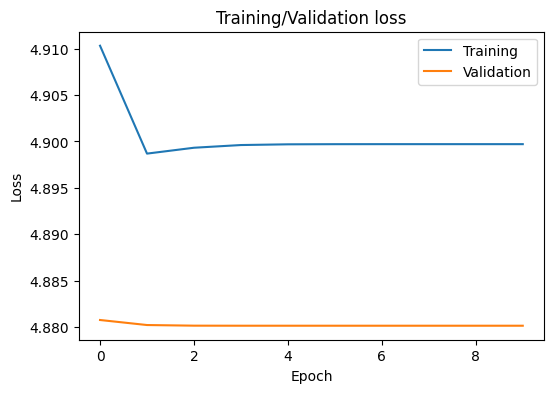

In [12]:
plt.figure(figsize=(6,4))
plt.plot(train_result[0],label="Training")
plt.plot(train_result[3],label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training/Validation loss")
plt.legend()
plt.show()

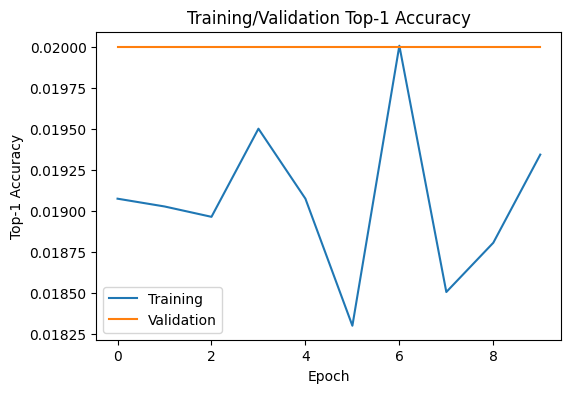

In [13]:
plt.figure(figsize=(6,4))
plt.plot(train_result[1],label="Training")
plt.plot(train_result[4],label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Top-1 Accuracy")
plt.title("Training/Validation Top-1 Accuracy")
plt.legend()
plt.show()

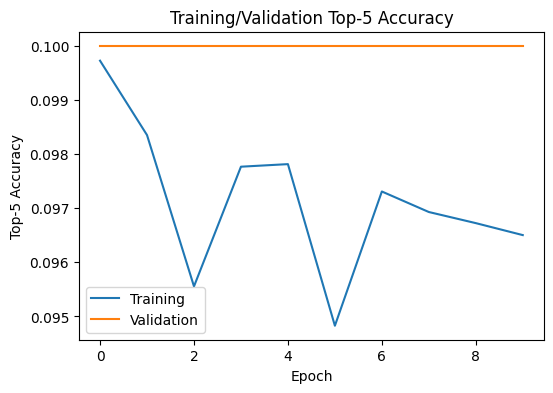

In [14]:
plt.figure(figsize=(6,4))
plt.plot(train_result[2],label="Training")
plt.plot(train_result[5],label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Top-5 Accuracy")
plt.title("Training/Validation Top-5 Accuracy")
plt.legend()
plt.show()

In [30]:
total_test_acc = 0
total_test_acc_top5 = 0
test_index = np.arange(len(test_label))
test_num_batch = len(test_index)//32

for data in tqdm(range(test_num_batch)):
    test_batch_img = test_feat[data*32 : (data+1)*32]
    test_batch_label = test_label[data*32 : (data+1)*32]

    output = lenet.predict(np.expand_dims(test_batch_img,axis=3))
    test_correct = (output.argmax(1) == test_batch_label.argmax(1)).sum()
    total_test_acc += test_correct
    label = test_batch_label.argmax(1)
    acc_top5 = len([i for i in range(len(label)) if label[i] in np.argsort(-output,axis=1)[i,:5]])
    total_test_acc_top5 += acc_top5
print("Test top1 accuracy:{}".format(total_test_acc/len(test_index)))
print("Test top5 accuracy:{}".format(total_test_acc_top5/len(test_index)))

  7%|▋         | 1/14 [00:00<00:04,  2.84it/s]

[[0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 ...
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]]


 14%|█▍        | 2/14 [00:00<00:04,  2.63it/s]

[[0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 ...
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]]


 21%|██▏       | 3/14 [00:01<00:04,  2.55it/s]

[[0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 ...
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]]


 29%|██▊       | 4/14 [00:01<00:04,  2.45it/s]

[[0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 ...
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]]


 36%|███▌      | 5/14 [00:01<00:03,  2.58it/s]

[[0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 ...
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]]


 43%|████▎     | 6/14 [00:02<00:03,  2.63it/s]

[[0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 ...
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]]


 50%|█████     | 7/14 [00:02<00:02,  2.67it/s]

[[0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 ...
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]]


 57%|█████▋    | 8/14 [00:03<00:02,  2.76it/s]

[[0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 ...
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]]


 64%|██████▍   | 9/14 [00:03<00:01,  2.85it/s]

[[0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 ...
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]]


 71%|███████▏  | 10/14 [00:03<00:01,  2.91it/s]

[[0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 ...
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]]


 79%|███████▊  | 11/14 [00:03<00:01,  2.95it/s]

[[0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 ...
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]]


 86%|████████▌ | 12/14 [00:04<00:00,  2.98it/s]

[[0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 ...
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]]


 93%|█████████▎| 13/14 [00:04<00:00,  2.99it/s]

[[0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 ...
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]]


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]

[[0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 ...
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]]
Test top1 accuracy:0.02
Test top5 accuracy:0.1


In [ ]:
# lenet.predict(np.expand_dims(test_feat,axis=3))
# tp = np.sum(pred == test_label)
# accuracy = float(tp) / len(test_label)
# accuracy

In [ ]:
# class conv():
#     def __init__(self,kernel_size):
#         self.size = kernel_size
#         self.weight = np.random.randn(kernel_size,kernel_size)
#     def forward(self,x): # x: number of image, number of channel, image height, image width
#         num_img, num_cha, height, width = x.shape
#         pool_height = height - self.size + 1
#         pool_width = width - self.size + 1
#         output = np.zeros((pool_height,pool_width))
#         for i in range(num_img):
#             for j in range(num_cha):
#                 for k in range(pool_height):
#                     for l in range(pool_width):
#                         output[k,l] = np.sum(x[i,j,k:k+self.size,l:l+self.size] * self.weight)

In [ ]:
# class maxpool():
#     def __init__(self,kernel_size):
#         self.size = kernel_size
#     def forward(self,x): # x: number of image, number of channel, image height, image width
#         num_img, num_cha, height, width = x.shape
#         pool_height = height - self.size + 1
#         pool_width = width - self.size + 1
#         output = np.zeros((num_img,num_cha,pool_height,pool_width))
#         for i in range(num_img):
#             for j in range(num_cha):
#                 for k in range(pool_height):
#                     for l in range(pool_width):
#                         output[i,j,k,l] = x[i,j,k:k+self.size,l:l+self.size].max()


In [ ]:
# class crossentropy(): # softmax->neg log likelihood
#     def __init__(self):
#         self.softmax = softmax()
#     def forward(self,pred,gt):
#         pred = self.softmax.forward(pred)
#         loss = self.negloglike(pred,gt)
#         return loss

#     def negloglike(self,pred,gt):
#         loss_matrix = np.sum(gt * np.log(pred),axis=1)
#         loss_sum = round(-sum(loss_matrix),5)
#         return loss_sum/len(pred)

In [ ]:
# class LeNet5(Net):
#     # LeNet5

#     def __init__(self):
#         self.conv1 = Conv(1, 6, 5)
#         self.ReLU1 = ReLU()
#         self.pool1 = MaxPool(2,2)
#         self.conv2 = Conv(6, 16, 5)
#         self.ReLU2 = ReLU()
#         self.pool2 = MaxPool(2,2)
#         self.FC1 = FC(16*4*4, 120)
#         self.ReLU3 = ReLU()
#         self.FC2 = FC(120, 84)
#         self.ReLU4 = ReLU()
#         self.FC3 = FC(84, 10)
#         self.Softmax = Softmax()

#         self.p2_shape = None

#     def forward(self, X):
#         h1 = self.conv1._forward(X)
#         a1 = self.ReLU1._forward(h1)
#         p1 = self.pool1._forward(a1)
#         h2 = self.conv2._forward(p1)
#         a2 = self.ReLU2._forward(h2)
#         p2 = self.pool2._forward(a2)
#         self.p2_shape = p2.shape
#         fl = p2.reshape(X.shape[0],-1) # Flatten
#         h3 = self.FC1._forward(fl)
#         a3 = self.ReLU3._forward(h3)
#         h4 = self.FC2._forward(a3)
#         a5 = self.ReLU4._forward(h4)
#         h5 = self.FC3._forward(a5)
#         a5 = self.Softmax._forward(h5)
#         return a5

#     def backward(self, dout):
#         #dout = self.Softmax._backward(dout)
#         dout = self.FC3._backward(dout)
#         dout = self.ReLU4._backward(dout)
#         dout = self.FC2._backward(dout)
#         dout = self.ReLU3._backward(dout)
#         dout = self.FC1._backward(dout)
#         dout = dout.reshape(self.p2_shape) # reshape
#         dout = self.pool2._backward(dout)
#         dout = self.ReLU2._backward(dout)
#         dout = self.conv2._backward(dout)
#         dout = self.pool1._backward(dout)
#         dout = self.ReLU1._backward(dout)
#         dout = self.conv1._backward(dout)

#     def get_params(self):
#         return [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b]

#     def set_params(self, params):
#         [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b] = params